In [1]:
base = '/home2/ebrahim/beyond-brainscore/'
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import os
from sklearn.metrics import mean_squared_error
import sys
sys.path.append(f'f{base}')
from plotting_functions import plot_test_perf_across_layers, plot_across_subjects, save_fMRI_simple, single_seed_mse_r2, find_rows_without_nan, pass_info_plot_hist2d
from untrained_results_funcs import compute_p_val, arrange_pvals_pd, remove_neg_r2, voxel_corrected_LLM_nested_full, mse_max_model, pool_across_seeds
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib
from scipy.stats import ttest_rel, ttest_1samp
import nibabel as nib
from nilearn import plotting
from nilearn import surface
from nilearn import datasets
import brainio
from matplotlib import pyplot as plt
from scipy.stats import wilcoxon

In [9]:
data_path = '/data/LLMs/data_processed/pereira/dataset/'
llm_acts_path = '/data/LLMs/data_processed/pereira/LLM_acts/'
results_path = '/data/LLMs/brainscore/results_pereira/untrained/'
general_res_path = '/data/LLMs/brainscore/results_pereira/'
figurePath = '/home2/ebrahim/beyond-brainscore/analyze_results/figures_code/figures/pereira_untrained_updated/'

In [10]:
model_name = 'gpt2-xl'
sp_str = '-sp' # set to empty to load last token model
N = 10 # number of random seeds

In [11]:
exp = ['243', '384']
br_labels_dict = {}
num_vox_dict = {}
ytest_dict = {}
mse_intercept_dict = {}
subjects_dict = {}
for e in exp:
    bre = np.load(f'{data_path}networks_{e}.npy', allow_pickle=True)
    br_labels_dict[e] = bre
    num_vox_dict[e] = bre.shape[0]
    mse_intercept_dict[e] = np.load(f'{general_res_path}mse_intercept_{e}.npy')
    ytest_dict[e] = np.load(f'{general_res_path}y_test_ordered_{e}.npy')
    subjects_dict[e] = np.load(f"{data_path}/subjects_{e}.npy", allow_pickle=True)

In [6]:
def load_best_layer(exp, model_name, N, sp_str):
    best_layer_lang = []
    best_layer_lang_pearson = []
    for i in range(N):
        keys = list(dict(np.load(f'{llm_acts_path}X_{model_name}-untrained-sp-{exp}_m{i}.npz')).keys())
        bil_lang = [k for k in keys if 'lang' in k and 'pearson' not in k][0]
        bil_lang_pearson = [k for k in keys if 'lang_pearson' in k][0]
        best_layer_lang.append(bil_lang.replace('_lang', ''))
        best_layer_lang_pearson.append(bil_lang_pearson.replace('_lang_pearson', ''))
    
        
    return best_layer_lang, best_layer_lang_pearson

bl_lang_243, bl_lang_pearson_243 = load_best_layer('243', model_name, N, sp_str)
bl_lang_384, bl_lang_pearson_384 = load_best_layer('384', model_name, N, sp_str)

### Across layer performance

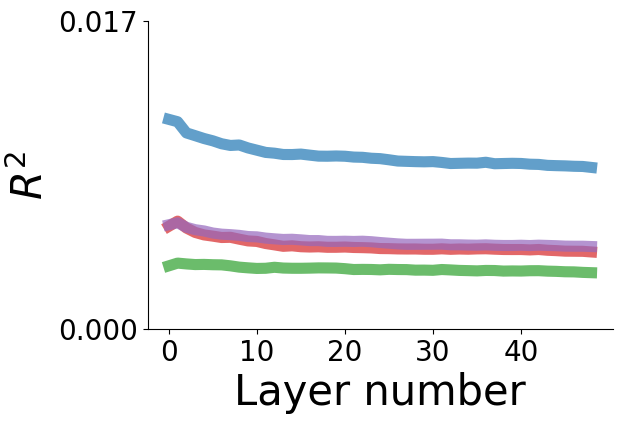

In [40]:
N = 10
yticks=[]
networks = ['language', 'DMN', 'MD', 'visual']
model_names = [f'gpt2-xl-untrained{sp_str}' for i in range(N)]
layers_range = [[0,48] for i in range(N)]
layer_name_arr = [f'layer_' for i in range(0,48)]
model_nums = np.arange(N)
colors = {}
colors_arr = ['tab:blue', 'tab:green', 'tab:red', 'tab:purple']
for i, n in enumerate(networks):
    colors[n] = colors_arr[i]
figurePath = ''
res_pd_384 = plot_test_perf_across_layers(model_names, dataset='pereira', layers_range=layers_range,
                             layer_name_arr=layer_name_arr, saveName='gpt2l-ut_perf_across_layers_384', 
                             figurePath=figurePath, resultsFolder=results_path, yticks=[0, .017], exp='384', 
                             model_nums=model_nums,
                             networks=networks, br_labels=br_labels_dict['384'], 
                             subjects=subjects_dict['384'], colors=colors, plot_legend=False, gpt_sp_perf=None)



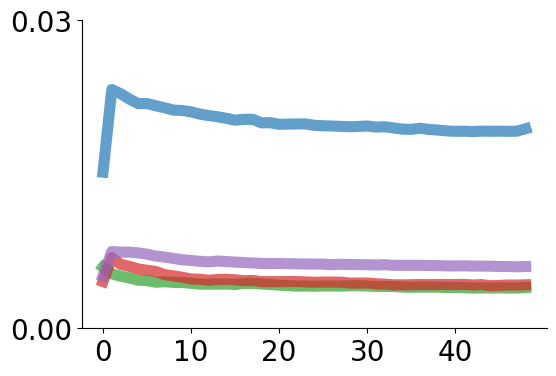

In [26]:
res_pd_243 = plot_test_perf_across_layers(model_names, dataset='pereira', layers_range=layers_range,
                             layer_name_arr=layer_name_arr, saveName='gpt2l-ut_perf_across_layers_243', 
                             figurePath=figurePath, resultsFolder=resultsFolder, yticks=[0, 0.03], exp='243', 
                             model_nums=model_nums,ylabel=False, xlabel=False, 
                             networks=networks, br_labels=br_labels_dict['243'], 
                             subjects=subjects_dict['243'], colors=colors, plot_legend=False, gpt_sp_perf=None)

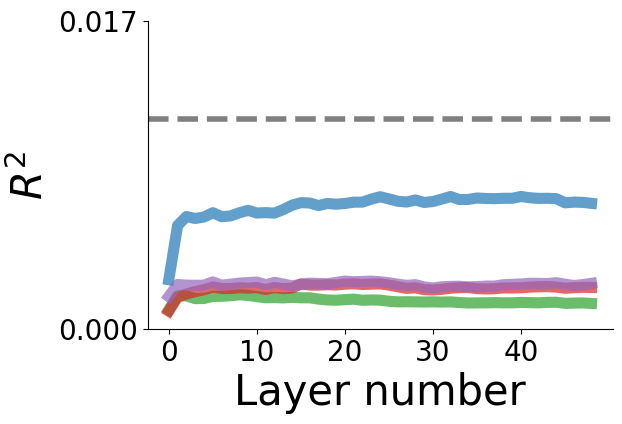

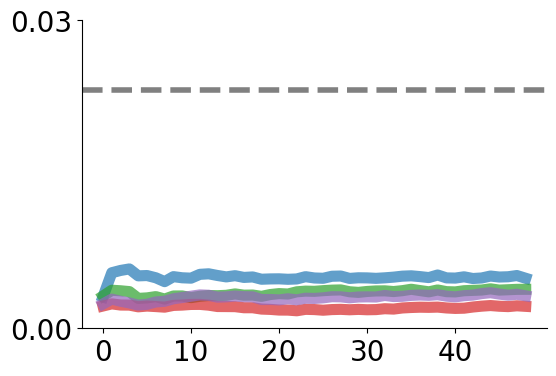

In [30]:
# plot last token results 

model_names = [f'gpt2-xl-untrained' for i in range(N)]

gpt2_sp_384_max = np.max(res_pd_384.loc[res_pd_384.Network=='language'].r2.values)
gpt2_sp_243_max = np.max(res_pd_243.loc[res_pd_243.Network=='language'].r2.values)

res_pd_384 = plot_test_perf_across_layers(model_names, dataset='pereira', layers_range=layers_range,
                             layer_name_arr=layer_name_arr, saveName='gpt2l-ut_lt_perf_across_layers_384', 
                             figurePath=figurePath, resultsFolder=resultsFolder, yticks=[0, .017], exp='384', 
                             model_nums=model_nums,
                             networks=networks, br_labels=br_labels_dict['384'], 
                             subjects=subjects_dict['384'], colors=colors, plot_legend=False, gpt_sp_perf=gpt2_sp_384_max)
res_pd_243 = plot_test_perf_across_layers(model_names, dataset='pereira', layers_range=layers_range,
                             layer_name_arr=layer_name_arr, saveName='gpt2l-ut_lt_perf_across_layers_243', 
                             figurePath=figurePath, resultsFolder=resultsFolder, yticks=[0, 0.03], exp='243', 
                             model_nums=model_nums,ylabel=False, xlabel=False, 
                             networks=networks, br_labels=br_labels_dict['243'], 
                             subjects=subjects_dict['243'], colors=colors, plot_legend=False, gpt_sp_perf=gpt2_sp_243_max)

### Load pooled mse and r2

In [12]:
# load mse value for BIL only model
mse_bil_243, r2_bil_243 = pool_across_seeds(ytest_dict['243'],np.repeat('gpt2-xl-untrained-sp', N), np.repeat('243', N), 
                                              bl_lang_243, niters=np.repeat(1,N), resultsFolder=resultsFolder)
mse_bil_384, r2_bil_384 = pool_across_seeds(ytest_dict['384'],np.repeat('gpt2-xl-untrained-sp', N), np.repeat('384', N), 
                                              bl_lang_384, niters=np.repeat(1,N), resultsFolder=resultsFolder)

# load mse value for BIL only model
mse_bil_PW_243, r2_bil_PW_243 = pool_across_seeds(ytest_dict['243'],np.repeat('gpt2-xl-ut_bil-lang_POSWN', N), np.repeat('243', N), 
                                              np.repeat('layer1', N), niters=np.repeat(1000,N), resultsFolder=resultsFolder, seed_last=False)
mse_bil_PW_384, r2_bil_PW_384 = pool_across_seeds(ytest_dict['384'],np.repeat('gpt2-xl-ut_bil-lang_POSWN', N), np.repeat('384', N), 
                                              np.repeat('layer1', N), niters=np.repeat(1000,N), resultsFolder=resultsFolder, seed_last=False)

# load mse value for BIL only model
mse_bil_W_243, r2_bil_W_243 = pool_across_seeds(ytest_dict['243'],np.repeat('gpt2-xl-ut_bil-lang_WN', N), np.repeat('243', N), 
                                              np.repeat('layer1', N), niters=np.repeat(1000,N), resultsFolder=resultsFolder, seed_last=False)
mse_bil_W_384, r2_bil_W_384 = pool_across_seeds(ytest_dict['384'],np.repeat('gpt2-xl-ut_bil-lang_WN', N), np.repeat('384', N), 
                                              np.repeat('layer1', N), niters=np.repeat(1000,N), resultsFolder=resultsFolder, seed_last=False)

# load mse value for BIL only model
mse_bil_P_243, r2_bil_P_243 = pool_across_seeds(ytest_dict['243'],np.repeat('gpt2-xl-ut_bil-lang_POS', N), np.repeat('243', N), 
                                              np.repeat('layer1', N), niters=np.repeat(1000,N), resultsFolder=resultsFolder, seed_last=False)
mse_bil_P_384, r2_bil_P_384 = pool_across_seeds(ytest_dict['384'],np.repeat('gpt2-xl-ut_bil-lang_POS', N), np.repeat('384', N), 
                                              np.repeat('layer1', N), niters=np.repeat(1000,N), resultsFolder=resultsFolder, seed_last=False)

# load non BIL models 
mse_PW_243, r2_PW_243 = single_seed_mse_r2(ytest_dict['243'], 'positional_WN', niters=1000, exp='243', layer_name='layer1', resultsFolder=resultsFolder)
mse_PW_384, r2_PW_384 = single_seed_mse_r2(ytest_dict['384'], 'positional_WN', niters=1000, exp='384', layer_name='layer1', resultsFolder=resultsFolder)

mse_P_243, r2_P_243 = single_seed_mse_r2(ytest_dict['243'], 'positional_simple', niters=1, exp='243', layer_name='layer1', resultsFolder=resultsFolder)
mse_P_384, r2_P_384 = single_seed_mse_r2(ytest_dict['384'], 'positional_simple', niters=1, exp='384', layer_name='layer1', resultsFolder=resultsFolder)

mse_W_243, r2_W_243 = single_seed_mse_r2(ytest_dict['243'], 'word-num', niters=1, exp='243', layer_name='layer1', resultsFolder=resultsFolder)
mse_W_384, r2_W_384 = single_seed_mse_r2(ytest_dict['384'], 'word-num', niters=1, exp='384', layer_name='layer1', resultsFolder=resultsFolder)

NameError: name 'resultsFolder' is not defined

In [47]:
non_nan_384 = find_rows_without_nan(np.vstack((r2_W_384, r2_P_384, r2_PW_384, r2_bil_384, r2_bil_W_384, r2_bil_P_384, r2_bil_PW_384)))
non_nan_243 = find_rows_without_nan(np.vstack((r2_W_243, r2_P_243, r2_PW_243, r2_bil_243, r2_bil_W_243, r2_bil_P_243, r2_bil_PW_243)))

In [51]:
# store r2 valeus into a pd dataframe
model_names = ['SL', 'SP', 'SP+SL', 'GPT2-XLU', 'SL+GPT2-XLU', 'SP+GPT2-XLU', 'SP+SL+GPT2-XLU']
best_DEM_model = model_names[2]
best_LLM_model = model_names[-1]
LLM_name = model_names[3]
num_models = len(model_names)
voxels_ids_243 = np.tile(np.arange(num_vox_dict['243']), num_models)
br_labels_243 = np.tile(br_labels_dict['243'], num_models)
model_order_243 = np.repeat(np.array(model_names), num_vox_dict['243'])

r2_stacked_243 = np.concatenate((r2_W_243, r2_P_243, r2_PW_243, r2_bil_243, r2_bil_W_243, r2_bil_P_243, r2_bil_PW_243))
r2_stacked_pd_243 = pd.DataFrame({'Model': model_order_243, 'r2':r2_stacked_243, 'voxel_id': voxels_ids_243, 
                                  'Network': br_labels_243, 'subjects': np.tile(subjects_dict['243'], num_models)}).dropna()


voxels_ids_384 = np.tile(np.arange(num_vox_dict['384']), num_models)
br_labels_384 = np.tile(br_labels_dict['384'], num_models)
model_order_384 = np.repeat(np.array(model_names), num_vox_dict['384'])
r2_stacked_384 = np.concatenate((r2_W_384, r2_P_384, r2_PW_384, r2_bil_384, r2_bil_W_384, r2_bil_P_384, r2_bil_PW_384))

r2_stacked_pd_384 = pd.DataFrame({'Model': model_order_384, 'r2':r2_stacked_384, 'voxel_id': voxels_ids_384, 
                                   'Network': br_labels_384, 
                                   'subjects': np.tile(subjects_dict['384'], num_models)}).dropna()


network_order=['language', 'DMN', 'MD', 'visual']

<Figure size 640x480 with 0 Axes>

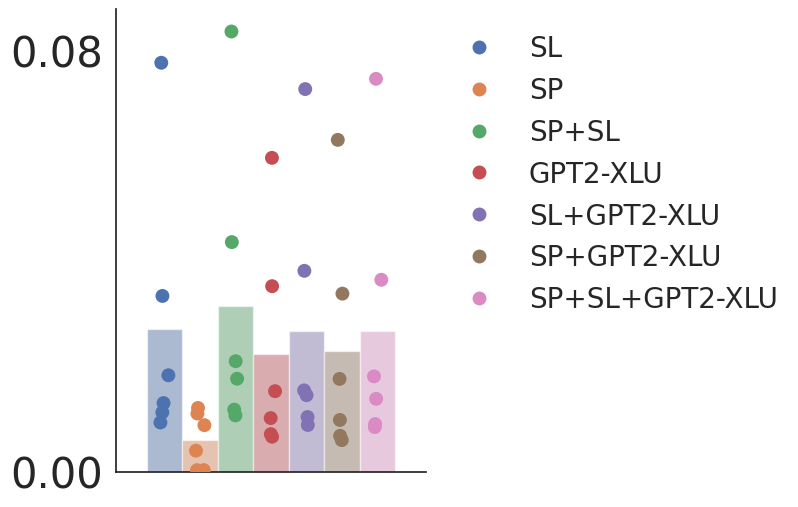

In [54]:
subj_avg_pd_243, _, _ = plot_across_subjects(r2_stacked_pd_243.copy(), selected_networks=['language'],
                                             figurePath=figurePath, 
                                             saveName='243_across_subjects_xl_untrained', hue_order=model_names, yticks=[0,0.08], 
                                                order=['language'], clip_zero=True, plot_legend=True, ylabel=False)

In [19]:
subj_avg_pd_243_ri = subj_avg_pd_243.reset_index()
subj_avg_pd_243_ri = subj_avg_pd_243_ri.drop(columns=['voxel_id'])
subj_243_lang = subj_avg_pd_243_ri.loc[subj_avg_pd_243_ri.Network=='language']
filtered_df = subj_243_lang[(subj_243_lang['Model'].isin([best_DEM_model, best_LLM_model]))]
filtered_df

,subjects,Network,Model,r2
3,018,language,GPT2-XLU+SP+SL,0.018068
6,018,language,SP+SL,0.020953
10,215,language,GPT2-XLU+SP+SL,0.009020
13,215,language,SP+SL,0.011751
17,288,language,GPT2-XLU+SP+SL,0.013804
20,288,language,SP+SL,0.017623
24,289,language,GPT2-XLU+SP+SL,0.036420
27,289,language,SP+SL,0.043573
31,296,language,GPT2-XLU+SP+SL,0.008439
34,296,language,SP+SL,0.010654


<Figure size 640x480 with 0 Axes>

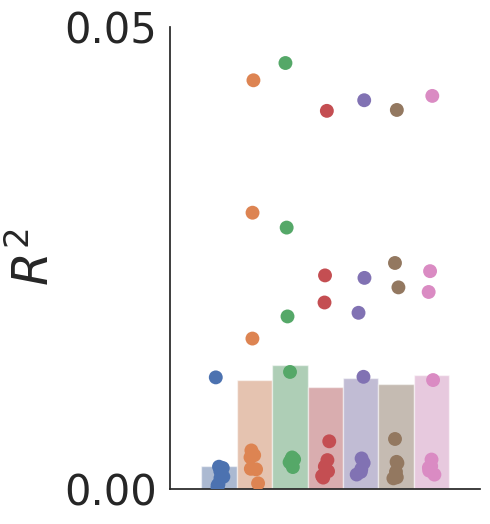

In [55]:
subj_avg_pd_384, _, _ = plot_across_subjects(r2_stacked_pd_384.copy(), selected_networks=['language'],
                                             figurePath=figurePath, 
                                             saveName='384_across_subjects_xl_untrained', hue_order=model_names, yticks=[0,0.05], 
                                                order=['language'], clip_zero=True, plot_legend=False)

In [104]:
subj_avg_pd_384_ri = subj_avg_pd_384.reset_index()
subj_avg_pd_384_ri = subj_avg_pd_384_ri.drop(columns=['voxel_id'])
subj_384_lang = subj_avg_pd_384_ri.loc[subj_avg_pd_384_ri.Network=='language']
filtered_df = subj_384_lang[(subj_384_lang['Model'].isin([best_DEM_model, best_LLM_model]))]
filtered_df

,subjects,Network,Model,r2
3,018,language,GPT2-XLU+SP+SL,0.011737
6,018,language,SP+SL,0.012613
10,199,language,GPT2-XLU+SP+SL,0.001502
13,199,language,SP+SL,0.002842
17,288,language,GPT2-XLU+SP+SL,0.002415
20,288,language,SP+SL,0.002320
24,289,language,GPT2-XLU+SP+SL,0.023523
27,289,language,SP+SL,0.028237
31,296,language,GPT2-XLU+SP+SL,0.003133
34,296,language,SP+SL,0.003103


0.955**
FLIPPED


/home3/ebrahim/what-is-brainscore/analyze_results/figures_code/plotting_functions.py:492: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  


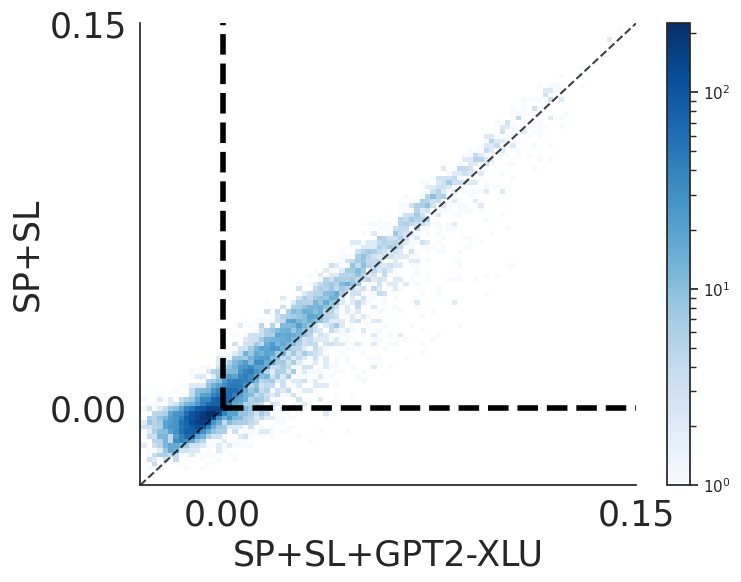

0.918**
FLIPPED


/home3/ebrahim/what-is-brainscore/analyze_results/figures_code/plotting_functions.py:492: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  


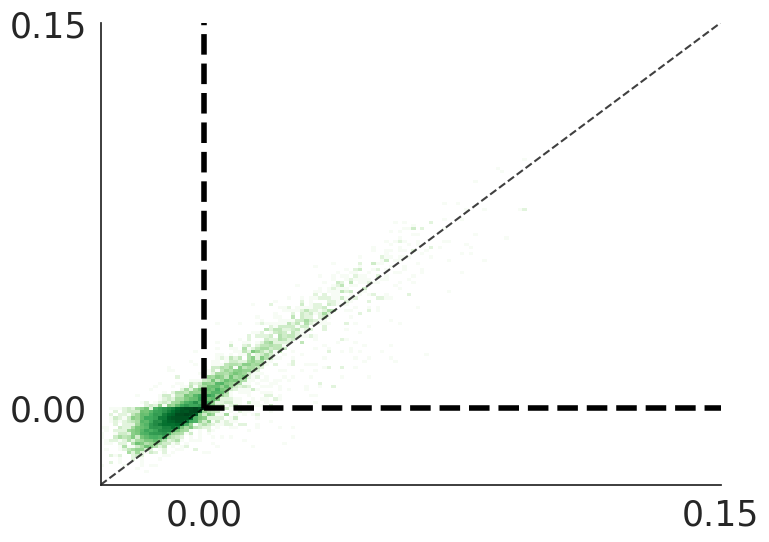

0.909**
FLIPPED


/home3/ebrahim/what-is-brainscore/analyze_results/figures_code/plotting_functions.py:492: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  


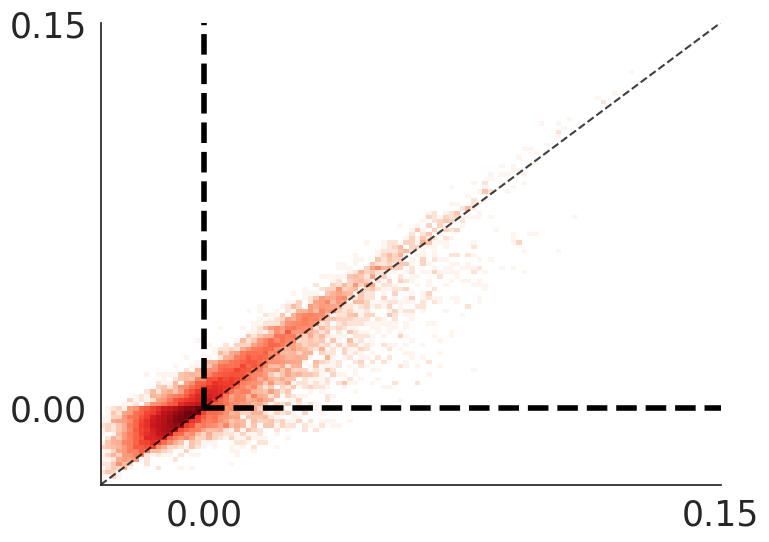

0.923**
FLIPPED


/home3/ebrahim/what-is-brainscore/analyze_results/figures_code/plotting_functions.py:492: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  


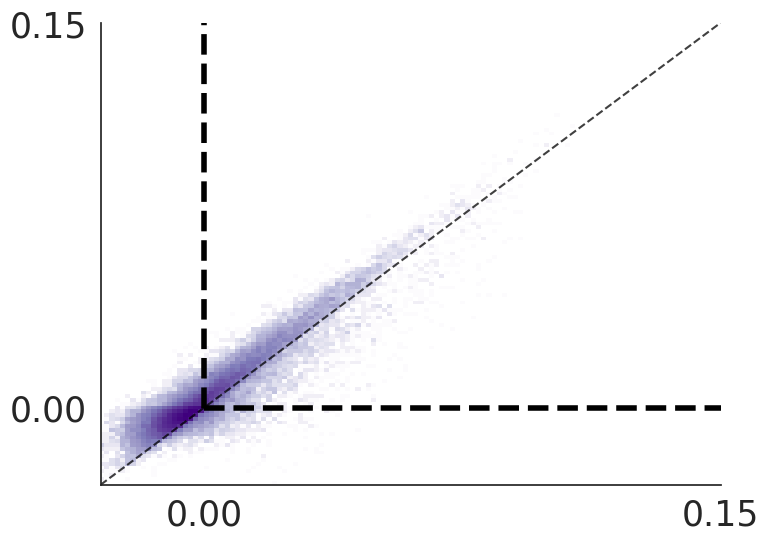

In [64]:
pass_info_plot_hist2d(max_val_dict={'language': 0.15, 'DMN': 0.15, 'MD':0.15, 'visual': 0.15}, min_val=-0.03,
                      df=r2_stacked_pd_384, best_DEM_model=best_DEM_model, best_LLM_model=best_LLM_model, 
                      figurePath=figurePath, saveName='scatter_384_xl_ut')

0.963**
FLIPPED


/home3/ebrahim/what-is-brainscore/analyze_results/figures_code/plotting_functions.py:492: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  


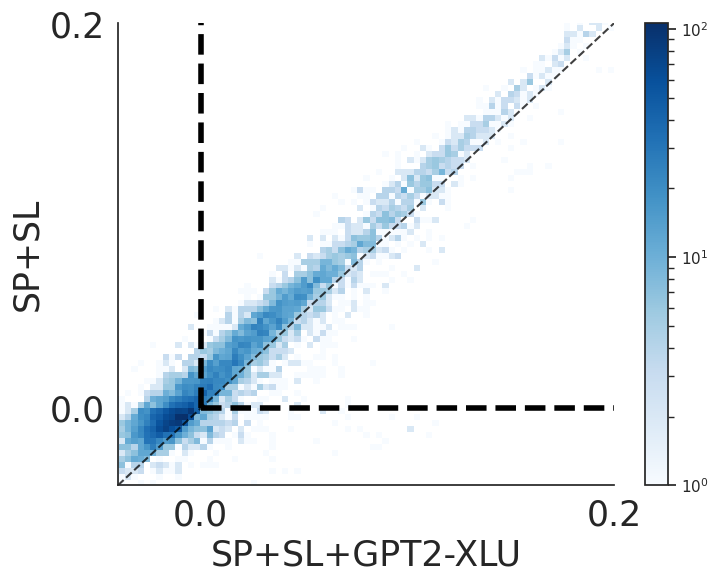

0.88**
FLIPPED


/home3/ebrahim/what-is-brainscore/analyze_results/figures_code/plotting_functions.py:492: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  


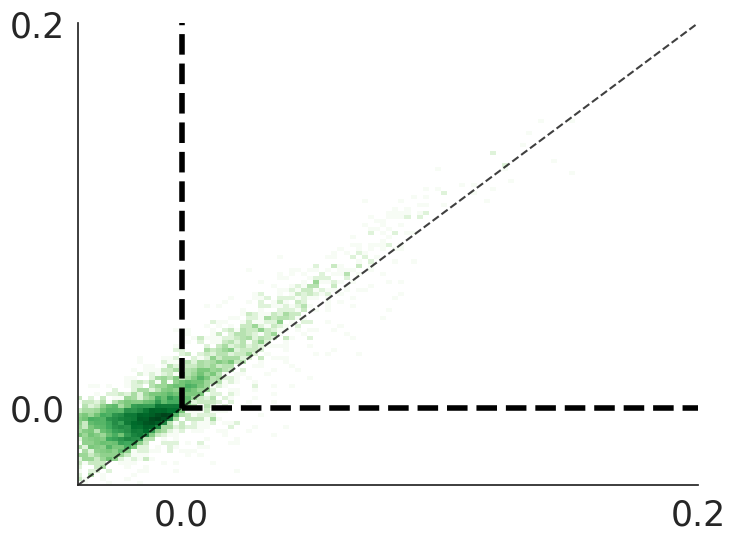

0.729**
FLIPPED


/home3/ebrahim/what-is-brainscore/analyze_results/figures_code/plotting_functions.py:492: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  


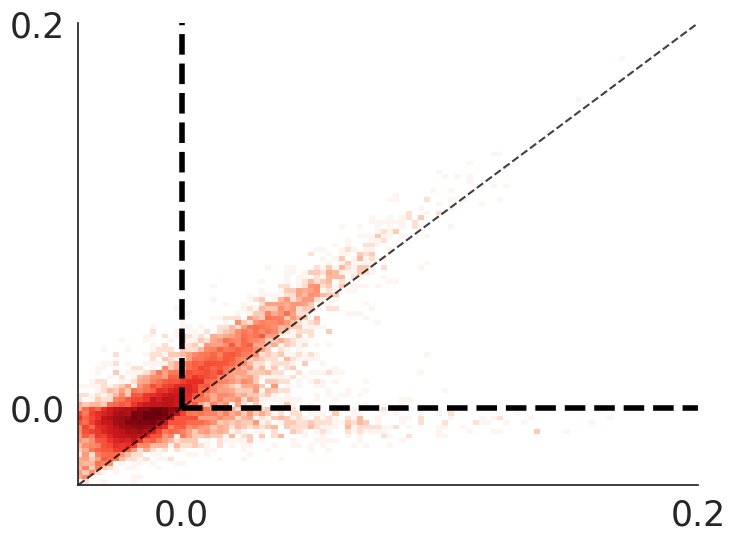

0.881**
FLIPPED


/home3/ebrahim/what-is-brainscore/analyze_results/figures_code/plotting_functions.py:492: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  


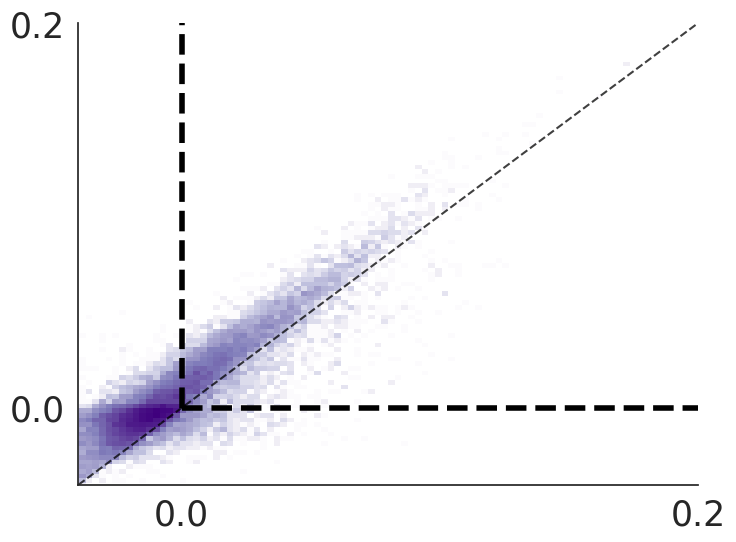

In [65]:
pass_info_plot_hist2d(max_val_dict={'language': 0.20, 'DMN': 0.20, 'MD':0.20, 'visual': 0.20}, 
                      min_val=-0.04, df=r2_stacked_pd_243, best_DEM_model=best_DEM_model, best_LLM_model=best_LLM_model, 
                      figurePath=figurePath, saveName='scatter_243_xl_ut')

### Significant testing perf voxel

In [66]:
pvals_243_BLPW_PW = compute_p_val('243', num_vox_dict, mse_bil_PW_243, mse_PW_243)
pvals_384_BLPW_PW = compute_p_val('384', num_vox_dict, mse_bil_PW_384, mse_PW_384)
pvals_243_BLPW_PW = pvals_243_BLPW_PW[non_nan_243]
pvals_384_BLPW_PW = pvals_384_BLPW_PW[non_nan_384]
pvals_pd_243 = arrange_pvals_pd(pvals_243_BLPW_PW, '243', subjects_dict, br_labels_dict, non_nan_243)
pvals_pd_384 = arrange_pvals_pd(pvals_384_BLPW_PW, '384', subjects_dict, br_labels_dict, non_nan_384)
psig_384_before_fdr = pvals_pd_384.loc[pvals_pd_384.pvals < 0.05].shape[0]/len(pvals_pd_384) * 100
psig_384_after_fdr = pvals_pd_384.loc[pvals_pd_384.pvals_adj < 0.05].shape[0]/len(pvals_pd_384) * 100
psig_243_before_fdr = pvals_pd_243.loc[pvals_pd_243.pvals < 0.05].shape[0]/len(pvals_pd_243) * 100
psig_243_after_fdr = pvals_pd_243.loc[pvals_pd_243.pvals_adj < 0.05].shape[0]/len(pvals_pd_243) * 100
print("384", psig_384_before_fdr, psig_384_after_fdr)
print("243", psig_243_before_fdr, psig_243_after_fdr)

384 1.2559853864695139 0.0010808824324178257
243 1.4242928452579036 0.07820299500831947


In [69]:
pvals_pd_384 = pvals_pd_384.loc[pvals_pd_384.network=='language']
pvals_pd_243 = pvals_pd_243.loc[pvals_pd_243.network=='language']
psig_384_before_fdr = pvals_pd_384.loc[pvals_pd_384.pvals < 0.05].shape[0]/len(pvals_pd_384) * 100
psig_384_after_fdr = pvals_pd_384.loc[pvals_pd_384.pvals_adj < 0.05].shape[0]/len(pvals_pd_384) * 100
psig_243_before_fdr = pvals_pd_243.loc[pvals_pd_243.pvals < 0.05].shape[0]/len(pvals_pd_243) * 100
psig_243_after_fdr = pvals_pd_243.loc[pvals_pd_243.pvals_adj < 0.05].shape[0]/len(pvals_pd_243) * 100
print("384", psig_384_before_fdr, psig_384_after_fdr)
print("243", psig_243_before_fdr, psig_243_after_fdr)

384 1.8291175743593968 0.0
243 1.3323371933756691 0.0


# Voxel-wise corrections, Figure 2c, d

In [70]:
BL_mod_384, non_BL_mod_384, full_mod_384 = \
            voxel_corrected_LLM_nested_full(r2_stacked_pd_384, LLM_name, best_DEM_model, best_LLM_model)

/home3/ebrahim/what-is-brainscore/analyze_results/figures_code/untrained_results_funcs.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['r2'] = np.clip(df['r2'], a_min=0, a_max=None)


In [71]:
BL_mod_243, non_BL_mod_243, full_mod_243 = \
            voxel_corrected_LLM_nested_full(r2_stacked_pd_243, LLM_name, best_DEM_model, best_LLM_model)

/home3/ebrahim/what-is-brainscore/analyze_results/figures_code/untrained_results_funcs.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['r2'] = np.clip(df['r2'], a_min=0, a_max=None)


In [72]:
mse_PW_384_concat = mse_max_model(np.stack((mse_W_384, mse_P_384, mse_PW_384))[:, :, non_nan_384])
mse_bil_PW_384_concat = mse_max_model(np.stack((mse_bil_384, mse_bil_W_384, mse_bil_P_384, mse_bil_PW_384))[:, :, non_nan_384])

mse_PW_243_concat = mse_max_model(np.stack((mse_W_243, mse_P_243, mse_PW_243))[:, :, non_nan_243])
mse_bil_PW_243_concat = mse_max_model(np.stack((mse_bil_243, mse_bil_W_243, mse_bil_P_243, mse_bil_PW_243))[:, :, non_nan_243])

### significance tests after voxel-wise corrections

In [73]:
pvals_243_BLPW_PW = compute_p_val('243', num_vox_dict, mse_bil_PW_243_concat.T, mse_PW_243_concat.T)
pvals_384_BLPW_PW = compute_p_val('384', num_vox_dict, mse_bil_PW_384_concat.T, mse_PW_384_concat.T)
pvals_pd_243 = arrange_pvals_pd(pvals_243_BLPW_PW, '243', subjects_dict, br_labels_dict, non_nan_243)
pvals_pd_384 = arrange_pvals_pd(pvals_384_BLPW_PW, '384', subjects_dict, br_labels_dict, non_nan_384)
psig_384_before_fdr = pvals_pd_384.loc[pvals_pd_384.pvals < 0.05].shape[0]/len(pvals_pd_384) * 100
psig_384_after_fdr = pvals_pd_384.loc[pvals_pd_384.pvals_adj < 0.05].shape[0]/len(pvals_pd_384) * 100
psig_243_before_fdr = pvals_pd_243.loc[pvals_pd_243.pvals < 0.05].shape[0]/len(pvals_pd_243) * 100
psig_243_after_fdr = pvals_pd_243.loc[pvals_pd_243.pvals_adj < 0.05].shape[0]/len(pvals_pd_243) * 100
print("384", psig_384_before_fdr, psig_384_after_fdr)
print("243", psig_243_before_fdr, psig_243_after_fdr)

384 1.006301544580996 0.0
243 1.1813643926788686 0.05158069883527454


In [74]:
pvals_pd_384 = pvals_pd_384.loc[pvals_pd_384.network=='language']
pvals_pd_243 = pvals_pd_243.loc[pvals_pd_243.network=='language']
psig_384_before_fdr = pvals_pd_384.loc[pvals_pd_384.pvals < 0.05].shape[0]/len(pvals_pd_384) * 100
psig_384_after_fdr = pvals_pd_384.loc[pvals_pd_384.pvals_adj < 0.05].shape[0]/len(pvals_pd_384) * 100
psig_243_before_fdr = pvals_pd_243.loc[pvals_pd_243.pvals < 0.05].shape[0]/len(pvals_pd_243) * 100
psig_243_after_fdr = pvals_pd_243.loc[pvals_pd_243.pvals_adj < 0.05].shape[0]/len(pvals_pd_243) * 100
print("384", psig_384_before_fdr, psig_384_after_fdr)
print("243", psig_243_before_fdr, psig_243_after_fdr)

384 1.2606080580044492 0.0
243 0.9463329597808492 0.0


In [75]:
modified_384 = pd.concat((non_BL_mod_384, full_mod_384))
modified_243 = pd.concat((non_BL_mod_243, full_mod_243))

In [76]:
default_palette = sns.color_palette("deep")
default_palette

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

<Figure size 640x480 with 0 Axes>

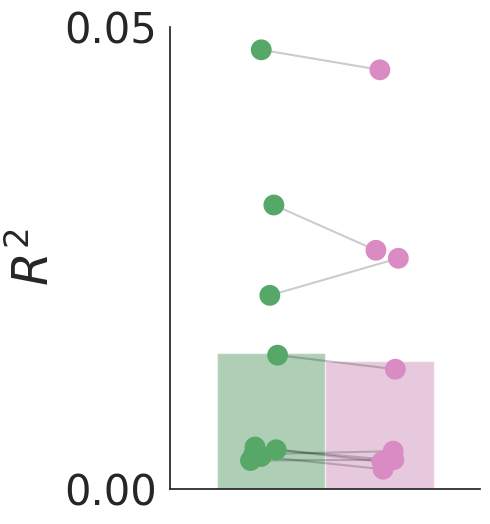

In [77]:
_, _, _ = plot_across_subjects(modified_384.copy(), figurePath=figurePath, selected_networks=['language'],
                                             saveName='384_across_subjects_xl_untrained_mod', hue_order=[best_DEM_model, best_LLM_model], 
                                             yticks=[0,0.05], order=['language'], clip_zero=True, color_palette=[default_palette[2], 
                                             default_palette[6]], draw_lines=True, ms=15, width=0.7)

<Figure size 640x480 with 0 Axes>

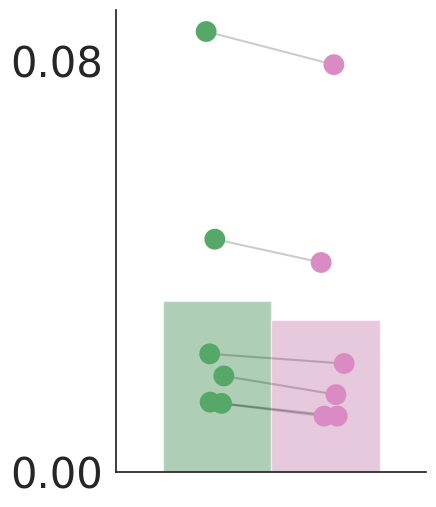

In [78]:
_, _, _ = plot_across_subjects(modified_243.copy(), figurePath=figurePath, selected_networks=['language'],
                                             saveName='243_across_subjects_xl_untrained_mod', hue_order=[best_DEM_model, best_LLM_model], 
                                             yticks=[0,0.08], 
                                                order=['language'], clip_zero=True, color_palette=[default_palette[2], default_palette[6]], draw_lines=True, ms=15, width=0.7, 
                                                ylabel=False)

In [80]:
PW_corrected_r2_243 = modified_243.loc[modified_243.Model=='SP+SL'].r2.values
BLPW_corrected_r2_243 = modified_243.loc[modified_243.Model=='SP+SL+GPT2-XLU'].r2.values

plotting_folder = "/data/LLMs/Pereira/plotting_data/"
subjects, stored_data_exp_WN_pos = save_fMRI_simple(PW_corrected_r2_243, exp='243', 
                        subjects_to_plot=np.unique(subjects_dict['243']), 
                        subjects_all=subjects_dict['243'], save_name='SP+SL_243') 

subjects, stored_data_exp_WN_pos = save_fMRI_simple(BLPW_corrected_r2_243, exp='243', 
                        subjects_to_plot=np.unique(subjects_dict['243']), 
                        subjects_all=subjects_dict['243'], save_name='GPT2-XLU+SP+SL_243')

plotting.plot_glass_brain(f'{plotting_folder}SP+SL_243_426.nii', 
                            colorbar=False, display_mode='xz', vmax=0.3, output_file=f'{figurePath}glass_brain_SP+SL_243_426.pdf')
plotting.plot_glass_brain(f'{plotting_folder}GPT2-XLU+SP+SL_426.nii', 
                            colorbar=True, display_mode='xz', vmax=0.3, output_file=f'{figurePath}glass_brain_GPT2-XLU+SP+SL_243_426.pdf')

/home3/ebrahim/miniconda3/envs/llama/lib/python3.11/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(
/home3/ebrahim/miniconda3/envs/llama/lib/python3.11/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


In [82]:
PW_corrected_r2_384 = np.clip(modified_384.loc[modified_384.Model=='SP+SL'].r2.values, 0, np.inf)
BLPW_corrected_r2_384 = np.clip(modified_384.loc[modified_384.Model=='SP+SL+GPT2-XLU'].r2.values, 0, np.inf)

plotting_folder = "/data/LLMs/Pereira/plotting_data/"
subjects, stored_data_exp_WN_pos = save_fMRI_simple(PW_corrected_r2_384, exp='384', 
                        subjects_to_plot=np.unique(subjects_dict['384']), 
                        subjects_all=subjects_dict['384'][non_nan_384].squeeze(), save_name='SP+SL_384')

subjects, stored_data_exp_WN_pos = save_fMRI_simple(BLPW_corrected_r2_384, exp='384', 
                        subjects_to_plot=np.unique(subjects_dict['384'][non_nan_384].squeeze()), 
                        subjects_all=subjects_dict['384'][non_nan_384].squeeze(), save_name='GPT2-XLU+SP+SL_384')

plotting.plot_glass_brain(f'{plotting_folder}SP+SL_384_343.nii', 
                            colorbar=False, display_mode='xz',
                            vmax=0.20, output_file=f'{figurePath}glass_brain_SP+SL_384_343.pdf')
plotting.plot_glass_brain(f'{plotting_folder}GPT2-XLU+SP+SL_384_343.nii', 
                            colorbar=True, display_mode='xz',
                            vmax=0.20, output_file=f'{figurePath}glass_brain_GPT2-XLU+SP+SL_384_343.pdf')

/home3/ebrahim/miniconda3/envs/llama/lib/python3.11/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(
/home3/ebrahim/miniconda3/envs/llama/lib/python3.11/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(
